# Classificação de Atividade Humana com PCA

Vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [9]:
# Importando bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# Carregando e definindo o dataset
filename_features = r"C:\Users\chris\OneDrive\Documentos\EBAC\Cientista de dados\Módulo 27\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\features.txt"
filename_labels = r"C:\Users\chris\OneDrive\Documentos\EBAC\Cientista de dados\Módulo 27\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\activity_labels.txt"

filename_subtrain = r"C:\Users\chris\OneDrive\Documentos\EBAC\Cientista de dados\Módulo 27\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\train\subject_train.txt"
filename_xtrain = r"C:\Users\chris\OneDrive\Documentos\EBAC\Cientista de dados\Módulo 27\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt"
filename_ytrain = r"C:\Users\chris\OneDrive\Documentos\EBAC\Cientista de dados\Módulo 27\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt"

filename_subtest = r"C:\Users\chris\OneDrive\Documentos\EBAC\Cientista de dados\Módulo 27\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\test\subject_test.txt"
ffilename_xtest = r"C:\Users\chris\OneDrive\Documentos\EBAC\Cientista de dados\Módulo 27\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\test\X_test.txt"
filename_ytest = r"C:\Users\chris\OneDrive\Documentos\EBAC\Cientista de dados\Módulo 27\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\test\y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#").squeeze("columns")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze("columns")
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze("columns")
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Façamos duas análises de componentes principais para a base do HAR - com e sem padronização:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes escolheríamos, em cada caso para explicar 90% da variância?

In [11]:
%%time

# Definição da função 'padroniza'
def padroniza(s):
    # Verifica se o desvio padrão da série (coluna) é maior que zero para evitar a divisão por zero.
    if s.std() > 0:
        # Padroniza a série subtraindo a média e dividindo pelo desvio padrão.
        s = (s - s.mean()) / s.std()
    # Retorna a série padronizada.
    return s

# Aplica a função 'padroniza' a cada coluna de X_train e armazena o resultado em X_train_pad.
X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)

# Exibe as primeiras linhas do DataFrame resultante.
X_train_pad.head()

CPU times: total: 1.08 s
Wall time: 1.09 s


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
2609,0.039104,0.021105,-0.003259,-0.873167,-0.958999,-0.933660,-0.866182,-0.958399,-0.943561,-0.865150,...,1.217148,-0.497812,-0.572938,-0.358451,-0.807966,-0.481792,-1.462152,1.835915,-2.545510,-0.804941
5045,0.987116,0.630785,0.939357,1.057811,1.435287,1.872867,1.002468,1.442618,1.947476,1.033808,...,0.547429,-0.566819,-0.635244,-0.212035,-0.435627,1.130879,1.398391,-0.092449,0.687782,1.264867
7224,0.038708,0.023157,0.127967,-0.844470,-0.899401,-0.862899,-0.848245,-0.900872,-0.877301,-0.794690,...,-1.247843,-0.431714,-0.525632,-0.415759,0.581155,0.578785,0.697570,-0.498070,0.051511,-0.394890
409,0.279237,0.059032,-0.046932,-0.863461,-0.904065,-0.900526,-0.856312,-0.901382,-0.908300,-0.850296,...,-0.473631,-0.722125,-0.711465,-0.260970,1.170111,0.562193,-0.344918,1.897211,-1.977109,-1.471764
3643,0.059687,0.096179,0.043133,-0.875274,-0.967965,-0.923521,-0.867410,-0.966968,-0.929398,-0.870452,...,0.758354,0.307131,0.445814,0.175980,-0.326582,-0.325624,-1.873799,-0.422540,0.757186,-0.031437


In [12]:
df = pd.DataFrame(X_train).apply(padroniza, axis=0)

pca = PCA()

n_componentes = df.shape[1]

princomp = pca.fit(df)

componentes = princomp.transform(df)

nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

principalDf = pd.DataFrame(data = componentes
             , columns = nomes_pca)

In [13]:
# Variância explicada por componente
princomp.explained_variance_

array([2.85187007e+02, 3.71132678e+01, 1.55836900e+01, 1.38263197e+01,
       1.04821490e+01, 9.61478063e+00, 7.69721138e+00, 6.75991327e+00,
       5.59346466e+00, 5.36209041e+00, 4.96855064e+00, 4.45726427e+00,
       4.26876948e+00, 3.67899682e+00, 3.64031955e+00, 3.35263189e+00,
       3.31175995e+00, 3.25163962e+00, 3.15967790e+00, 2.93770446e+00,
       2.84650103e+00, 2.76579055e+00, 2.70120415e+00, 2.61485508e+00,
       2.55936653e+00, 2.35481536e+00, 2.32424960e+00, 2.27902323e+00,
       2.20233228e+00, 2.18687239e+00, 2.05789366e+00, 2.03546096e+00,
       1.93029049e+00, 1.89578321e+00, 1.86559587e+00, 1.82942979e+00,
       1.79444456e+00, 1.65938484e+00, 1.62366198e+00, 1.59846443e+00,
       1.53753203e+00, 1.51200649e+00, 1.49275047e+00, 1.45122040e+00,
       1.37899006e+00, 1.37213793e+00, 1.34072332e+00, 1.30455548e+00,
       1.29917936e+00, 1.28240026e+00, 1.24137444e+00, 1.19880293e+00,
       1.17164039e+00, 1.12654741e+00, 1.12451120e+00, 1.10449166e+00,
      

In [14]:
# Variância explicada acumulada por componente

princomp.explained_variance_ratio_.cumsum()

array([0.50835474, 0.57451029, 0.60228871, 0.62693455, 0.64561931,
       0.66275796, 0.67647848, 0.68852823, 0.69849876, 0.70805685,
       0.71691345, 0.72485866, 0.73246788, 0.7390258 , 0.74551479,
       0.75149096, 0.75739427, 0.76319042, 0.76882265, 0.7740592 ,
       0.77913317, 0.78406328, 0.78887826, 0.79353932, 0.79810147,
       0.802299  , 0.80644205, 0.81050448, 0.81443021, 0.81832838,
       0.82199664, 0.82562491, 0.82906571, 0.832445  , 0.83577049,
       0.8390315 , 0.84223016, 0.84518806, 0.84808229, 0.8509316 ,
       0.8536723 , 0.8563675 , 0.85902837, 0.86161522, 0.86407331,
       0.86651919, 0.86890907, 0.87123448, 0.87355031, 0.87583623,
       0.87804902, 0.88018592, 0.88227441, 0.88428251, 0.88628699,
       0.88825578, 0.89020636, 0.89211558, 0.8940063 , 0.89583951,
       0.89765525, 0.89943363, 0.90118045, 0.90290381, 0.90460557,
       0.90626056, 0.90789588, 0.9095032 , 0.91110407, 0.91265168,
       0.91419009, 0.91570839, 0.91720014, 0.91866029, 0.92010

In [15]:
# Calcula a variância percentual por componente
princomp.explained_variance_ratio_ * 100

array([5.08354736e+01, 6.61555576e+00, 2.77784136e+00, 2.46458462e+00,
       1.86847575e+00, 1.71386464e+00, 1.37205194e+00, 1.20497563e+00,
       9.97052524e-01, 9.55809342e-01, 8.85659651e-01, 7.94521260e-01,
       7.60921476e-01, 6.55792659e-01, 6.48898316e-01, 5.97617092e-01,
       5.90331542e-01, 5.79614906e-01, 5.63222442e-01, 5.23654983e-01,
       5.07397689e-01, 4.93010794e-01, 4.81498066e-01, 4.66106074e-01,
       4.56215068e-01, 4.19753184e-01, 4.14304742e-01, 4.06242999e-01,
       3.92572598e-01, 3.89816825e-01, 3.66825964e-01, 3.62827265e-01,
       3.44080302e-01, 3.37929271e-01, 3.32548283e-01, 3.26101567e-01,
       3.19865340e-01, 2.95790524e-01, 2.89422813e-01, 2.84931271e-01,
       2.74069881e-01, 2.69519874e-01, 2.66087427e-01, 2.58684564e-01,
       2.45809280e-01, 2.44587867e-01, 2.38988114e-01, 2.32541084e-01,
       2.31582773e-01, 2.28591847e-01, 2.21278866e-01, 2.13690362e-01,
       2.08848555e-01, 2.00810589e-01, 2.00447629e-01, 1.96879084e-01,
      

In [19]:
# Calcula a variância percentual acumulada por componente
princomp.explained_variance_ratio_.cumsum() * 100

array([ 50.83547365,  57.4510294 ,  60.22887076,  62.69345538,
        64.56193113,  66.27579577,  67.64784771,  68.85282334,
        69.84987586,  70.80568521,  71.69134486,  72.48586612,
        73.24678759,  73.90258025,  74.55147857,  75.14909566,
        75.7394272 ,  76.31904211,  76.88226455,  77.40591953,
        77.91331722,  78.40632802,  78.88782608,  79.35393216,
        79.81014722,  80.22990041,  80.64420515,  81.05044815,
        81.44302075,  81.83283757,  82.19966354,  82.5624908 ,
        82.90657111,  83.24450038,  83.57704866,  83.90315023,
        84.22301557,  84.51880609,  84.8082289 ,  85.09316018,
        85.36723006,  85.63674993,  85.90283736,  86.16152192,
        86.4073312 ,  86.65191907,  86.89090718,  87.12344827,
        87.35503104,  87.58362289,  87.80490175,  88.01859211,
        88.22744067,  88.42825126,  88.62869889,  88.82557797,
        89.0206361 ,  89.21155807,  89.40062953,  89.58395053,
        89.76552501,  89.94336285,  90.11804521,  90.29

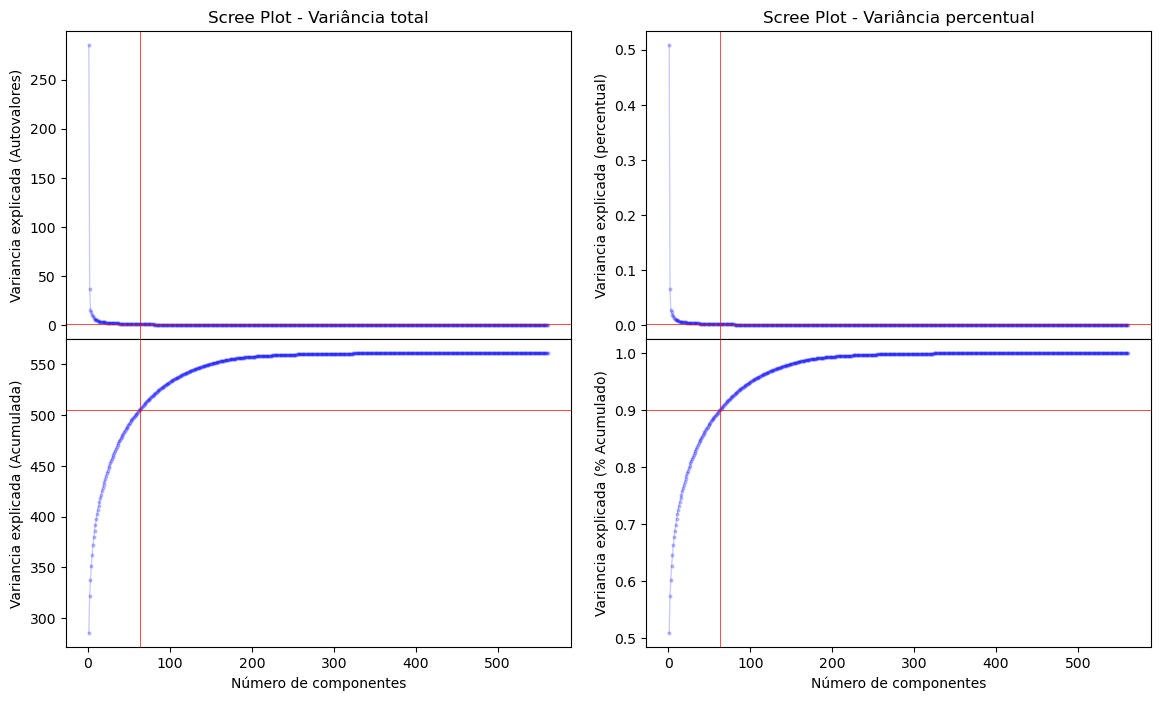

In [34]:
# Quantas componentes escolheríamos, em cada caso para explicar 90% da variância?

# % variância explicada

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = .90
ncomp = (princomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = princomp.explained_variance_[ncomp-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

Acurácia da Árvore de Decisão: 0.86


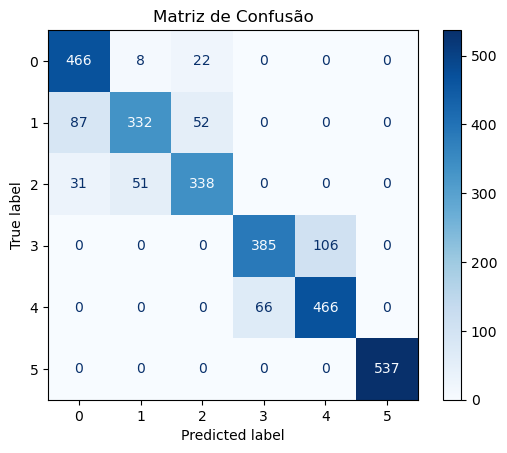

CPU times: total: 15.5 s
Wall time: 15.7 s


In [41]:
%%time 

# Primeira árvore sem padronizar

# Definir a árvore de decisão com ccp_alpha = 0.001
clf = DecisionTreeClassifier(random_state = 48151646, ccp_alpha=0.001)

# Treinar o modelo 
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia da Árvore de Decisão: {accuracy:.2f}')

# Calcular e exibir a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

Acurácia da Árvore de Decisão: 0.79


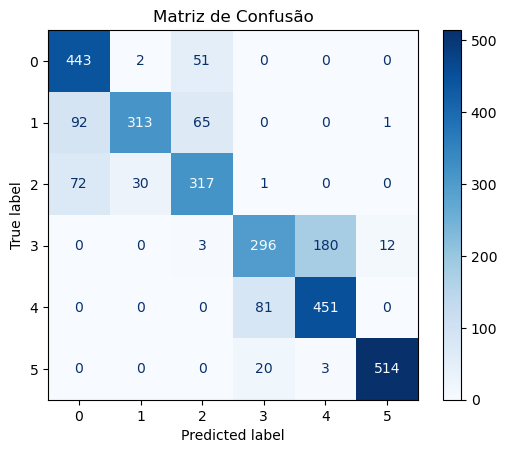

CPU times: total: 2.12 s
Wall time: 961 ms


In [42]:
%%time 

# Segunda árvore com padronização

# Redução de dimensionalidade usando PCA com 10 componentes principais
pca = PCA(n_components=10)
X_train_pad_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Definir a árvore de decisão com ccp_alpha = 0.001
clf = DecisionTreeClassifier(random_state = 48151646, ccp_alpha=0.001)

# Treinar o modelo no conjunto de treinamento reduzido
clf.fit(X_train_pad_pca, y_train)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test_pca)

# Avaliar a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia da Árvore de Decisão: {accuracy:.2f}')

# Calcular e exibir a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# Conclusão

1. Observamos que o tempo de processamento da primeira árvore é aproximadamente **15.5 segundos**, enquanto a árvore padronizada leva cerca de **2.12 segundos**, resultando em uma significativa redução de **86.45%** no tempo de execução.

2. Ao analisar as métricas de acurácia, notamos que a primeira árvore apresenta uma precisão de **86%**, enquanto a segunda árvore alcança **79%**, refletindo uma redução de **8.14%**.

Pode-se dizer que a melhoria de significativa no tempo de execução justifica a redução mínima na acurácia, nesse contexto.